#Data

loading or import the data here

This formulating assume fixed lengths of segments & fixed periods of groups to finish each segment which also means fixed speeds. Treats people as groups not individuals

how to make the model solve the problem with random length of roads,

<img src="https://drive.google.com/uc?export=view&id=1N4ZPOyCT2ltVFYheWJv5m6mEkgx_djP3" style="width:600px;height:300px;">


#solving the problem without gurobi

Data

combine segments with time slots with group first assignement for only the first tick, so segment subscript time slot

In [ ]:
import numpy as np

def describe_system_state(connected_segs, groups_starting, time_slots):
    num_groups = groups_starting.shape[0]
    num_segments = connected_segs.shape[0]
    num_ticks = time_slots.shape[1]

    # initialize a list to hold the system state descriptions
    system_state = []

    for i in range(num_groups):
        start_segment = np.argmax(groups_starting[i])
        if start_segment == -1:
            continue

        current_segment = start_segment
        group_state = []

        for t in range(num_ticks):
            if time_slots[i, t] == 1:
                # append the current state of the group
                state_description = (
                    [int(t == j) for j in range(num_ticks)],  # Group time slot state
                    [int(t == k) for k in range(num_ticks)]   # Segment state
                )
                group_state.append(state_description)

                # move to the next segment based on connections
                if t + 1 < num_ticks and time_slots[i, t + 1] == 1:
                    next_segment_found = False
                    for j in range(num_segments):
                        if connected_segs[current_segment, j] == 1 and j != current_segment:
                            # move to the next segment
                            current_segment = j
                            next_segment_found = True
                            break
                    if not next_segment_found:
                        break

        system_state.append(group_state)

    return system_state

connected_segs = np.array([[0,0,1,0],
                           [0,0,1,0],
                           [0,0,0,1],
                           [0,0,0,0]])
groups_starting = np.array([[1,0,0,0],
                            [0,1,0,0],
                            [0,0,1,0]])
time_slots = np.array([[1,1,1,0],
                       [0,1,1,1],
                       [0,0,0,1]])

system_state = describe_system_state(connected_segs, groups_starting, time_slots)
print(system_state)


[[([1, 0, 0, 0], [1, 0, 0, 0]), ([0, 1, 0, 0], [0, 1, 0, 0]), ([0, 0, 1, 0], [0, 0, 1, 0])], [([0, 1, 0, 0], [0, 1, 0, 0]), ([0, 0, 1, 0], [0, 0, 1, 0]), ([0, 0, 0, 1], [0, 0, 0, 1])], [([0, 0, 0, 1], [0, 0, 0, 1])]]


In [ ]:
import numpy as np
segments_connections = np.array([[0,0,1,0],
                           [0,0,1,0],
                           [0,0,0,1],
                           [0,0,0,0]]) # describe connection of segments, rows are segments, columns decribe what segment they are connected to.
                                       # Example: row 1 is segment 1, all columns are 0 except the third which means seg 1 is connected to seg3 and seg 3 connected to seg 4

starting_segments = np.array([[1,0,0,0], # the definition must change to show when the group start moving, by looking somehow at the array of time slots
                            [0,1,0,0],
                            [0,0,1,0]], dtype=np.int32) # describe starting segment of each group, 3 rows means 3 groups columns describe what seg they start at.

time_slots = np.array([[1,0,0,0], #variable
                       [0,1,0,0],
                       [0,0,0,1]], dtype=np.int32) # describe the movement of the groups which only moves forward from the segment they are currently in.
                                   # Example: the first row is the first group, moving 3 ticks forward from seg 1 to seg 3 to seg 4.
group_sizes = np.array([[150,200,300]], dtype=np.int32).T

max_capacity = np.array([[200,200,400,400]], dtype=np.int32).T
""" output an array that rows are for groups so 3 rows, [[(seg1, tick1, size_of_group1), (seg3, tick2, size_of_group1), (seg4, tick3, size_of_group1), (1 meaning reached destination, tick4, 0 no size)],
                                                         [(0 meaning did not start, tick1, 0), (seg2, tick2, size_of_group2), (seg3, tick3, size_of_group2), (seg4, tick4, size_of_group2)],
                                                         [(0, tick1, 0), (0 , tick2, 0), (0, tick3, 0), (seg3, tick4, size_of_group3)]]"""

' output an array that rows are for groups so 3 rows, [[(seg1, tick1, size_of_group1), (seg3, tick2, size_of_group1), (seg4, tick3, size_of_group1), (1 meaning reached destination, tick4, 0 no size)],\n                                                         [(0 meaning did not start, tick1, 0), (seg2, tick2, size_of_group2), (seg3, tick3, size_of_group2), (seg4, tick4, size_of_group2)],\n                                                         [(0, tick1, 0), (0 , tick2, 0), (0, tick3, 0), (seg3, tick4, size_of_group3)]]'

In [ ]:
np.count_nonzero(segments_connections[3,:])==0

True

In [ ]:
group_sizes.shape

(3, 1)

the starting point array is going to be used to determine what segment the group is going to start at!

              [
                [#group 1 movement
                                  [150,0,0,0],
                                  [0,0,150,0],
                                  [0,0,0,150],
                                  [0,0,0,0],
                                  [0,0,0,0]
                                  ]
  ,[#group 2 movement
                      [0,0,0,0],
                      [0,200,0,0],
                      [0,0,200,0],
                      [0,0,0,200],
                      [0,0,0,0]
                      ],

   [#group 3 movement
                      [0,0,0,0],
                      [0,0,0,0],
                      [0,0,0,0],
                      [0,0,300,0],
                      [0,0,0,300]
                      ]
              ]

   if you sum across columns in a tick the segment sum of people should not exceeds the capacity of the road
   [200, 300, 400, 300] for example

   

   depth describe the num of groups
   rows describe time ticks
   columns describe num of segments

In [ ]:
group_sizes[0,][0]

150

In [ ]:
def scheduling(group_sizes: np.ndarray, segments_connections: np.ndarray, time_slots: np.ndarray, starting_segments: np.ndarray, max_capacity: np.ndarray) -> (int, np.ndarray):
  num_groups = group_sizes.shape[0]       # depth
  num_ticks = time_slots.shape[1]          # rows
  num_segs = segments_connections.shape[0] # columns

  print(schedule_array:=np.zeros((num_groups, num_ticks, num_segs), dtype=np.int32))

  # the schedule array dims are num_groups, num_ticks, num_segs
  # schedule_array[0:num_groups,0:num_ticks,0:num_segs]

  ###populate the zeros array###

  #first i need to know what segment each group start at and "what tick they start at."
  ## IMPORTANT INFO: in theory in this problem once a group is dispatched they will move to the next segment at each tick. so, no stopping.
  ## THE QUESTION WHAT SEG THEY START AT, THE STARTING SEG MATRIX CANNOT BE CHANGED IT IS A GIVEN DATA
  ## AS FOR WHAT TICK THEY START AT, IS A VARIABLE MATRIX BUT SHOULD NOT VIOLATE THE CONSTRAINTS
  ## CONSTRAINTS ARE: 1-AT A TICK, THE SUM OF PEOPLE IN THE SAME SEGMENT SHOULD NOT EXCEED ROAD CAPACITY(need to validate the last schedule array matrix for some tick the some of each segment(across rows) should not violate the constraint)
  ##                  2-AT A CERTAIN TICK, THE SAME GROUP CANNOT BE ASSIGNED TO 2 DIFFERENT SEGMENTS(need to validate the final starting segment matrix and the other ticks matrices)
  ##                  3-THE MOVEMENT SHOULD NOT VIOLATE HOW SEGMENTS ARE CONNECTED, MEANING IF SEGMENT 1 IS CONNECTED TO 3 THEN ANY GROUP AT SEGMENT 1 CANNOT GO TO SEGMENT 2
  #lets answer what tick each group starts at
  time_vector_groups = []
  for i in range(num_groups):
    time_vector_groups.append(time_slots[i, :])

  starting_ticks = np.array([np.argmax(v) for v in time_vector_groups]).reshape(num_groups, -1)
  print('when each group starts at:', starting_ticks)
  print('the shape:', starting_ticks.shape)
  #now i know what tick(row) to put one in.
  #now what segment(column) to put the one in?
  #lets answer "what segment each group start at"

  starting_vector_groups = []
  for i in range(num_groups):
    starting_vector_groups.append(starting_segments[i,:])

  starting_points = np.array([np.argmax(v) for v in starting_vector_groups]).reshape(num_groups, -1)
  print('when each group starts at:', starting_points)
  print('the shape:', starting_points.shape)

  #now assign sizes for group num(depth) for a tick(row) at a seg(column)
  for i in range(num_groups): # i represent depth
    schedule_array[i, starting_ticks[i], starting_points[i]] = group_sizes[i,][0]

  print('modified schedule:', schedule_array)

  #move function
  #once groups dispatch they must move tell they reach the last segment(no stopping)
  for i in range(num_groups):
    s_tick = starting_ticks[i,][0]
    #print('s_tick:',s_tick)
    for j in range(num_ticks-(s_tick+1)): #range calc the remaining ticks
      j+=s_tick+1 # so the value of j starts at the starting tick
      #print(j)
      #where are they at now?
      s_seg = np.argmax(schedule_array[i,j-1,:]) #this will be used determine what segment in the connected segs matrix
      #the segment they are now at, what segment is it connected to?
      if(np.count_nonzero(segments_connections[s_seg,])==0): #last segment is not connected to anything
        schedule_array[i, j,:] = schedule_array[i, j,:]
      else:
        connection = np.argmax(segments_connections[s_seg,]) #connection of segment s_seg
        schedule_array[i, j, connection] = group_sizes[i,][0]
  print('modified schedule:\n', schedule_array)

  #1
  #constraint: of road capacity at certain tick for certain segment should not exceed C
  #print(f'people in seg {0} at time {0}:',np.sum(schedule_array[:,1,1], axis=0))
  for i in range(num_ticks):
    for j in range(num_segs):
      #print(f'people in seg {j} at time {i}:',schedule_array[:,i,j])
      if(not np.sum(schedule_array[:,i,j], axis=0) <= max_capacity[j,][0]):
        print(f'the sum of people in seg {j} at time {i}:',np.sum(schedule_array[:,i,j],axis=0),' exceeded ',max_capacity[j,][0])

  #2
  #contraint: a group cannot be at 2 different segs in a tick
  #_ = 0
  #print(np.count_nonzero(schedule_array[0,_,:]), schedule_array[0,_,:])
  for i in range(num_groups):
    for j in range(num_ticks):
      if(np.count_nonzero(schedule_array[i,j,:])!=1 and np.count_nonzero(schedule_array[i,j,:])!=0):
        print(f'group {i} at tick {j} is present in {np.count_nonzero(schedule_array[i,j,:])} different segments', schedule_array[i,j,:], )
  # ARGMAX WILL ONLY PUT THE GROUP AT THE FIRST OCCURANCE OF 1 SO EVEN IF YOU PUT MULTIPLE 1s GROUPS WILL BE ASSIGNED TO ONE SEGMENT THAT IS THE FIRST ONE ARGMAX WILL SEE(no need to validate)

  #3
  #constraint: the movement of groups should not violate how segments are connected
  #to achieve validitiy, we need to check where were they previously and where they are now, and see if they violated the connection or not (checking after the tick they started at!)
  for i in range(num_groups): #for this group when did they started?

    s_tick = starting_ticks[i,][0]
    if(s_tick==(num_ticks-1)): #reached the last tick there are no next ticks
      break
    next_tick = s_tick+1

    s_seg = np.argmax(schedule_array[i,s_tick,:]) #this will be used determine what segment in the connected segs matrix
    connection = np.argmax(segments_connections[s_seg,]) #connection of segment s_seg
    print(s_seg, connection)

    next_seg = np.argmax(schedule_array[i,next_tick,:]) #the segment where the group currently at should be in the connected segment where the previous segment connected to

    if(connection != next_seg):
      print(f'group {i} moved from segment {s_seg} at tick {s_tick} to segment {next_seg} at tick {next_tick}, when there is no connection between segment {s_seg} and next segment {next_seg}')

  #objective function
  cost=[]
  for i in range(num_ticks):
    for j in range(num_segs):
      cost.append(c[j]-np.sum(schedule_array[:,i,j], axis=0))
      print(f'cost of segment {j} is',cost[-1],f' at tick {i}')
  print('cost list', cost)
  print('total cost', total_cost:=np.sum(cost))
  return (total_cost, schedule_array)
  """
  print('the first tick of all groups: ', schedule_array[:,0:1,:])
  # this shows the position of all groups in the first tick

  populating_first_tick = group_sizes.T * schedule_array[:,0:1,:]
  print('position of the first group at first tick:', schedule_array[0:1, 0:1,:]) # this shows the first group position at the first tick
  """

  """ solve it using gurobipy """

In [ ]:
scheduling(group_sizes=group_sizes, segments_connections=segments_connections, time_slots=time_slots, starting_segments=starting_segments, max_capacity=max_capacity)

[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
when each group starts at: [[0]
 [1]
 [3]]
the shape: (3, 1)
when each group starts at: [[0]
 [1]
 [2]]
the shape: (3, 1)
modified schedule: [[[150   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0 200   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0 300   0]]]
modified schedule:
 [[[150   0   0   0]
  [  0   0 150   0]
  [  0   0   0 150]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0 200   0   0]
  [  0   0 200   0]
  [  0   0   0 200]]

 [[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0 300   0]]]
0 2
1 2
cost of segment 0 is 50  at tick 0
cost of segment 1 is 200  at tick 0
cost of segment 2 is 400  at tick 0
cost of segment 3 is 400  at tick 0
cost of segment 0 is 200  at tick 1
cost of se

(3450,
 array([[[150,   0,   0,   0],
         [  0,   0, 150,   0],
         [  0,   0,   0, 150],
         [  0,   0,   0,   0]],
 
        [[  0,   0,   0,   0],
         [  0, 200,   0,   0],
         [  0,   0, 200,   0],
         [  0,   0,   0, 200]],
 
        [[  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0, 300,   0]]], dtype=int32))

variable X subscript group, tick, segment
[
    [
        [150 * x111,   0 * x121,   0 * x131,   0 * x141],
        [  0 * x112,   0 * x122, 150 * x132,   0 * x142],
        [  0 * x113,   0 * x123,   0 * x133, 150 * x143],
        [  0 * x114,   0 * x124,   0 * x134,   0 * x144]
    ],
    [
        [  0 * x211,   0 * x221,   0 * x231,   0 * x241],
        [  0 * x212, 200 * x222,   0 * x232,   0 * x242],
        [  0 * x213,   0 * x223, 200 * x233,   0 * x243],
        [  0 * x214,   0 * x224,   0 * x234, 200 * x244]
    ],
    [
        [  0 * x311,   0 * x321,   0 * x331,   0 * x341],
        [  0 * x312,   0 * x322,   0 * x332,   0 * x342],
        [  0 * x313,   0 * x323,   0 * x333,   0 * x343],
        [  0 * x314,   0 * x324, 300 * x334,   0 * x344]
    ]
]

equations are:
x111 = 150
x211 = 0
x311 = 0

x111 + x211 + x311 = road capacity
its constraints is:
x111 + x211 + x311 <= max capacity
is this considered 3 variables? do num of variable increase as num of groups increase too?

\[

\begin{bmatrix}
150 \cdot x_{111} & 0 \cdot x_{121} & 0 \cdot x_{131} & 0 \cdot x_{141} \\
0 \cdot x_{112} & 0 \cdot x_{122} & 150 \cdot x_{132} & 0 \cdot x_{142} \\
0 \cdot x_{113} & 0 \cdot x_{123} & 0 \cdot x_{133} & 150 \cdot x_{143} \\
0 \cdot x_{114} & 0 \cdot x_{124} & 0 \cdot x_{134} & 0 \cdot x_{144}
\end{bmatrix},
\begin{bmatrix}
0 \cdot x_{211} & 0 \cdot x_{221} & 0 \cdot x_{231} & 0 \cdot x_{241} \\
0 \cdot x_{212} & 200 \cdot x_{222} & 0 \cdot x_{232} & 0 \cdot x_{242} \\
0 \cdot x_{213} & 0 \cdot x_{223} & 200 \cdot x_{233} & 0 \cdot x_{243} \\
0 \cdot x_{214} & 0 \cdot x_{224} & 0 \cdot x_{234} & 200 \cdot x_{244}
\end{bmatrix},
\begin{bmatrix}
0 \cdot x_{311} & 0 \cdot x_{321} & 0 \cdot x_{331} & 0 \cdot x_{341} \\
0 \cdot x_{312} & 0 \cdot x_{322} & 0 \cdot x_{332} & 0 \cdot x_{342} \\
0 \cdot x_{313} & 0 \cdot x_{323} & 0 \cdot x_{333} & 0 \cdot x_{343} \\
0 \cdot x_{314} & 0 \cdot x_{324} & 300 \cdot x_{334} & 0 \cdot x_{344}
\end{bmatrix}

\]


#GUROBIPY

#Model 2

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 26.5 MB/s eta 0:00:00


##Solving the dummy data case in Dr. Felemban paper

In [ ]:
import gurobipy as gp
from gurobipy import GRB
from IPython.display import Image
import numpy as np

# constraint coefficients # read connection of segments from data or extract this information somehow
segments_connections = [[0,0,1,0],
                        [0,0,1,0],
                        [0,0,0,1],
                        [0,0,0,0]] # describe connection of segments, rows are segments, columns decribe what segment they are connected to.
                                       # Example: row 1 is segment 1, all columns are 0 except the third which means seg 1 is connected to seg3 and seg 3 connected to seg 4
num_segs = len(segments_connections[0])
# constriant coefficients # somehow see how to determine the starting segment of each group. and
starting_segments = [[1,0,0,0], # the definition must change to show when the group start moving, by looking somehow at the array of time slots
                     [0,1,0,0],
                      [0,0,1,0]] # describe starting segment of each group, 3 rows means 3 groups columns describe what seg they start at.

# constraint coefficients
time_slots = [[0,0,0],
              [0,0,0],
              [0,0,0]] # describe the movement of the groups which only moves forward from the segment they are currently in.
                                   # Example: the first row is the first group, moving 3 ticks forward from seg 1 to seg 3 to seg 4.
num_time = len(time_slots[0])
#sizes are also constraints
group_sizes = [150, 200, 300]
#group_sizes = [150]
num_groups = len(group_sizes)
#ground truth and constraint
c = [200,200,400,400]
# road capacity is our variable
print('num of segs ',num_segs)
print('num of ticks ',num_time)
print('num of groups ',num_groups)

num of segs  4
num of ticks  3
num of groups  3


Random generated

In [ ]:
num_groups = 3; num_segs = 4;
random_input = input_data_generator(
    max_num_groups = (num_groups, (1, 10)),  # 3 groups with sizes between 1 and 10
    max_num_segments= (num_segs, (2, 5)),   # 5 segments with sizes between 2 and 5
    max_ticks= (3, 3)        # ticks range between 5 and 10
)

In [ ]:
print_input_data(input_list := [group_sizes, starting_segments, num_time, segments_connections, c])
feasibility_check(input_list[0], input_list[1], input_list[2], input_list[3], input_list[4])

Generated Input Data:

Group Sizes:
[150, 200, 300]

Starting Segments (1 indicates start, 0 indicates no start):
Group 1: [1, 0, 0, 0]
Group 2: [0, 1, 0, 0]
Group 3: [0, 0, 1, 0]

Number of Ticks: 3

Segments Connections (1 indicates a connection, 0 indicates no connection):
Segment 1: [0, 0, 1, 0]
Segment 2: [0, 0, 1, 0]
Segment 3: [0, 0, 0, 1]
Segment 4: [0, 0, 0, 0]

Road Capacities:
[200, 200, 400, 4000]


True

In [ ]:
print_input_data(random_input)
feasibility_check(random_input[0], random_input[1], random_input[2], random_input[3], random_input[4])

Generated Input Data:

Group Sizes:
[8, 3, 9]

Starting Segments (1 indicates start, 0 indicates no start):
Group 1: [0, 1, 0, 0]
Group 2: [1, 0, 0, 0]
Group 3: [0, 0, 1, 0]

Number of Ticks: 3

Segments Connections (1 indicates a connection, 0 indicates no connection):
Segment 1: [0, 1, 0, 0]
Segment 2: [0, 0, 1, 0]
Segment 3: [0, 0, 0, 1]
Segment 4: [0, 0, 0, 0]

Road Capacities:
[199, 203, 123, 137]


True

In [ ]:
solved_model, groups_assignements, dispatch_time = scheduling_model_corrected(input_list)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 24 rows, 45 columns and 81 nonzeros
Model fingerprint: 0x83d8a9cb
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e+02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Found heuristic solution: objective 12450.000000
Presolve removed 24 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 12450 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.245000000000e+04, best bound 1.245000000000e+04, gap 0.0000%
Gurobi Optimizer version 11.0.3 build v11.0.

In [ ]:
print_solution(solved_model, groups_assignements, dispatch_time, input_data= [group_sizes, starting_segments, num_time, segments_connections, c])

Optimal solution found:

Group 1 at tick 1 in segment 1: 150.0
d[1,1] = 1.0
Group 1 at tick 2 in segment 3: 150.0
d[1,2] = 0.0
Group 1 at tick 3 in segment 4: 150.0
d[1,3] = 0.0
Group 2 at tick 1 in segment 2: 200.0
d[2,1] = 1.0
Group 2 at tick 2 in segment 3: 200.0
d[2,2] = 0.0
Group 2 at tick 3 in segment 4: 200.0
d[2,3] = 0.0
Group 3 at tick 1 in segment 3: 300.0
d[3,1] = 1.0
Group 3 at tick 2 in segment 4: 300.0
d[3,2] = 0.0
Group 3 at tick 3 in segment 4: 300.0
d[3,3] = 0.0


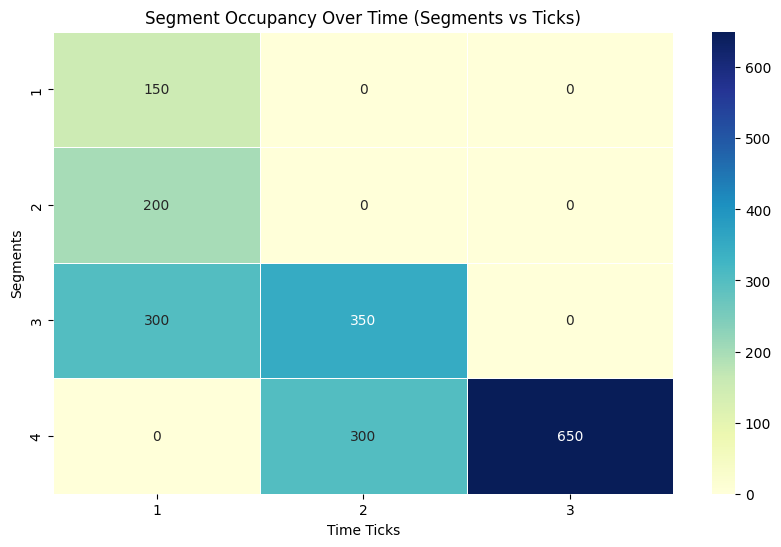

In [ ]:
visualize(solved_model, groups_assignements, dispatch_time, input_data= [group_sizes, starting_segments, num_time, segments_connections, c])

In [ ]:
print(segments_connections[0][2])

1


In [ ]:
print(num_groups, num_time, num_segs)

3 3 4


###variable

The aim to constraint the model to only able to modify the time of dispatch of each group: \\
-model should not violate the road max capacity by assigning multiple groups that the sum of them in the road exceeds the capacity. (DONE) \\
-model should not put a group in more than 1 segment in a certain tick. (DONE) \\
-model should not put groups at segments where they dont start at and at the variable starting tick d[i,j] decides.(not DONE) \\
-model should advance the movement of groups to next segments (cannot assign groups to previous segments) \\
-model cannot move a group forward to a segment that is not connected to the segment they are currently in. \\
-model can only tune when each group is dispatched

###Objective

###constraints

In [ ]:
m = gp.Model("schedule2")
r = m.addVars(num_groups, num_time, num_segs, lb=0, vtype=GRB.BINARY, name='group_presence_at_segment_at_a_tick') # num of groups determine the num of variables in the equation of capacity of each segment at each tick
d = m.addVars(num_groups, num_time, vtype=GRB.BINARY, name="dispatch") # this decision variable decide when a group is dispatched

m.setObjective(gp.quicksum(c[k] - gp.quicksum(r[i,j,k] * group_sizes[i] for i in range(num_groups)) for j in range(num_time) for k in range(num_segs)), sense=GRB.MINIMIZE)

"""
Constraint 1
This constraint tells gurobi to not violate the capacity constraint of each segment
"""
for j in range(num_time):
    for k in range(num_segs):
        m.addConstr(gp.quicksum(r[i,j,k] * group_sizes[i] for i in range(num_groups)) <= c[k], f"capacity_constraint_{j}_{k}")

"""
Constraint 2
This constraint tells gurobi that at a certain tick, groups can only be assigned to one segment at a time.
"""
for i in range(num_groups):
    for j in range(num_time):
        m.addConstr(gp.quicksum(r[i,j,k] for k in range(num_segs)) <= 1, f"group_assignment_constraint_{i}_{j}")

"""
Constraint 3
This constraint tells gurobi that d[i,j] (dispatch tick) can only have one value for each group.
"""
for i in range(num_groups):
    # Ensure that group i has only one starting tick j
    m.addConstr(gp.quicksum(d[i,j] for j in range(num_time)) == 1,
                name=f"group_{i+1}_single_start_tick")

#optimize to initialize d[i,j] to access attribute .X of the variable
m.optimize()

"""
Constraint 4
This constraint tells gurobi that if d[i,j] (which is what tick a group must move) is true at this tick, then the group must be dispatched
"""
for i in range(num_groups):
    for j in range(num_time-1):
        if d[i,j].X == 1:
          m.addConstr(gp.quicksum(r[i,j,k] for k in range(num_segs)) == 1) # the sum of every segment == 1 means they are only at one segment
"""
Constraint 5
This constraint tells gurobi to dispatch the groups at their starting segments
"""
for i in range(num_groups): # for every group there is only one d[i,j] = 1 at certain j, so instead of looking at starting segment and zeroing every previous and later segments
    for j in range(num_time):
      if d[i,j].X==1:
        # group i is only at its designated starting segment if it is dispatched at tick j
        for s in range(num_segs):
            if starting_segments[i][s] == 1:
              # If group i is dispatched at tick j, it must be at segment s (this logic does not consider that the starting tick j as a variable, so when exactly they should be dispatched is up to the solver)
              m.addConstr(r[i,j,s] == 1,
                          name=f"group_{i+1}_dispatch_at_correct_segment_at_J{j+1}")
            else:
              # group i is not at any other segment when dispatched
              m.addConstr(r[i,j,s] == 0,
                          name=f"group_{i+1}_not_dispatch_at_wrong_segment_at_J{j+1}")


Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 24 rows, 45 columns and 81 nonzeros
Model fingerprint: 0x3a5f5d2c
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e+02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective 1650.0000000
Presolve removed 17 rows and 35 columns
Presolve time: 0.00s
Presolved: 7 rows, 10 columns, 20 nonzeros
Variable types: 0 continuous, 10 integer (10 binary)

Root relaxation: cutoff, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

constraint 6: once a group is dispatched the group should advance foward and not stay at the same place every tick (good)

In [ ]:
for i in range(num_groups):
    for j in range(num_time - 1):
        for s1 in range(num_segs):
            for s2 in range(num_segs):
                #only allow movement from s1 to s2 if they are connected
                if segments_connections[s1][s2] == 0:
                    #print(f'Group {i+1}, Tick {j+1}, no movement allowed from Segment {s1+1} to Segment {s2+1}')
                    m.addConstr(r[i,j,s1] + r[i,j+1,s2] <= 1,
                                name=f"group_{i+1}_no_move_from_{s1}_to_{s2}_at_tick_{j+1}_to_{j+2}")


Constraint 7: when groups reach the final segemnt they should be removed from the scheduling process

In [ ]:
# for i in range(num_groups):
#     for j in range(num_time - 1):  #don't need to check the last tick
#         for s in range(num_segs - 1):  #exclude the last segment for now
#             #if the group reaches the last segment
#             m.addConstr((r[i, j, num_segs - 1] == 1) >> (r[i, j + 1, s] == 0),
#                         name=f"group_{i+1}_no_assignment_after_final_segment_at_tick{j+2}")

In [ ]:
# for i in range(num_groups):
#     for j in range(num_time - 1):  #only consider the ticks before the last one
#         for s1 in range(num_segs):
#             if sum(segments_connections[s1]) == 0:  #final segment has no outgoing connections
#                 #once group "i" reaches final segment s1 at time j, it should not be on any road after that
#                 for j_next in range(j + 1, num_time):
#                     for s2 in range(num_segs):
#                         m.addConstr(r[i, j_next, s2] == 0,
#                                     name=f"group_{i+1}_removed_after_reaching_final_segment_{s1+1}_at_tick_{j+1}")


In [ ]:
m.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 117 rows, 45 columns and 261 nonzeros
Model fingerprint: 0x42f4b590
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e+02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint group_3_dispatch_at_correct_segment_at_J1 by 1.000000000

Found heuristic solution: objective 1950.0000000
Presolve removed 117 rows and 45 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution 

In [ ]:
if m.status == GRB.OPTIMAL:
    for i in range(num_groups):
        for j in range(num_time):
            for k in range(num_segs):
              if r[i,j,k].X==1:
                print(f"group {i+1} at tick {j+1} in segment {k+1}: {r[i, j, k].X * group_sizes[i]}")
                print(f'd[{i+1},{j+1}]', d[i,j].X)
else:
    print("No optimal solution found.")

group 1 at tick 1 in segment 1: 150.0
d[1,1] 1.0
group 1 at tick 2 in segment 3: 150.0
d[1,2] 0.0
group 1 at tick 3 in segment 4: 150.0
d[1,3] 0.0
group 2 at tick 1 in segment 2: 200.0
d[2,1] 1.0
group 2 at tick 2 in segment 3: 200.0
d[2,2] 0.0
group 2 at tick 3 in segment 4: 200.0
d[2,3] 0.0
group 3 at tick 1 in segment 3: 300.0
d[3,1] 1.0
group 3 at tick 2 in segment 4: 300.0
d[3,2] 0.0


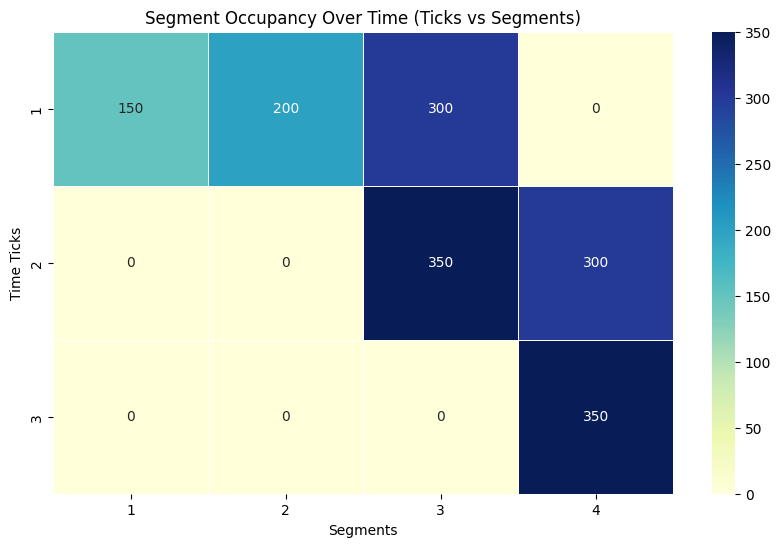

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

occupancy = np.zeros((num_segs, num_time))

if m.status == GRB.OPTIMAL:
    for i in range(num_groups):
        for j in range(num_time):
            for k in range(num_segs):
                if r[i, j, k].X == 1:
                    occupancy[k, j] += group_sizes[i]
else:
    print("No optimal solution found.")

occupancy_transposed = occupancy.T

plt.figure(figsize=(10, 6))
sns.heatmap(occupancy_transposed, annot=True, cmap="YlGnBu", cbar=True, linewidths=.5, fmt="g")

plt.xlabel("Segments")
plt.ylabel("Time Ticks")
plt.title("Segment Occupancy Over Time (Ticks vs Segments)")
plt.xticks(ticks=np.arange(num_segs) + 0.5, labels=np.arange(1, num_segs + 1))
plt.yticks(ticks=np.arange(num_time) + 0.5, labels=np.arange(1, num_time + 1))

plt.show()


#Test for scalibility

##Libraries

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 46.5 MB/s eta 0:00:00


In [ ]:
!grbgetkey 6954c55a-34ae-4ca1-8918-0fa44c03b4ea

/bin/bash: line 1: grbgetkey: command not found


In [ ]:
import gurobipy as gp
from gurobipy import GRB
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Union
import time
import random
import pickle

##Random Data Generation(Parameters)

###Old generator (no dummy segment generation)

In [ ]:
#Tuple with int (count) and Tuple[int, int] (range)
def input_data_generator(
    max_num_groups: Tuple[int, Tuple[int, int]],
    num_segments_range: Tuple[int, int],
    max_ticks: Tuple[int, int],
    ) -> Tuple[List[int], List[List[int]], int, List[List[int]], List[int]]:

    """
                          INPUT DATA

             1-group_sizes: List[int],
             2-starting_segments: List[List[int]],
             3-num_time: int,
             4-segments_connections: List[List[int]],
             5-road_capacities: List[int]
    """

    #step 1: number of ticks generation
    #data
    #here, the shape is a scalar
    num_ticks = random.randint(max_ticks[0], max_ticks[1])

    #step 2: groups generation
    #data
    #here, the shape is (num_groups, 1)
    group_sizes = [random.randint(max_num_groups[1][0], max_num_groups[1][1]) for _ in range(max_num_groups[0])]

    #step 3: generate the segment connectinos to later assign starting points (the final segment cannot be assigned to any group)
    #data
    #here, the connections are modelled, so the shape is (num_segments, num_segments)
    num_segments = random.randint(num_segments_range[0], num_segments_range[1])
    segments_connections = [[0] * num_segments for _ in range(num_segments)]  # Initialize matrix of zeros

    for i in range(num_segments - 1):  # Exclude the last segment
        # Each segment must connect to exactly one subsequent segment
        connected_segment = random.randint(i + 1, num_segments - 1)  # Choose one valid segment to connect to
        segments_connections[i][connected_segment] = 1  # Set the connection


    #segments_connections = [[random.randint(0, 1) for _ in range(num_segments)] for _ in range(num_segments)] THIS IMPLEMENTATION HAS: segemnts can connect to themselves, segments are not uniderictional
    #the connections data must be feasible, so there is a series of segments that does not lead to the final destination, the final segment must be all zeros (not connected to any segment)
    #[[random.randint(0, 1) for _ in range(random.randint(max_num_segments[1][0], max_num_segments[1][1]))] for _ in range(max_num_segments[0])]

    #make the final segment all zeros
    segments_connections[-1] = [0] * num_segments

    #Step 4: assigning starting point for each group
    #data
    #here, each group must have a starting segment, so the shape is (num_groups, num_segments)
    starting_segments = []
    for _ in range(max_num_groups[0]):
        start_points = [0] * num_segments  # Initialize all to 0
        valid_start_segment = random.randint(0, num_segments - 2)  # Ensure valid start before the final segment
        start_points[valid_start_segment] = 1  # Set a valid start at one segment
        starting_segments.append(start_points)



    #step 5: generate acceptable capacities for segments
    #data
    #here, an assignement for a capacity for each road, so the shape is (num_segments, 1)
    capacities = [random.randint(min(group_sizes) + 100, max(group_sizes) + 200) for _ in range(num_segments)]
    #road capacites must have acceptable values that allow pilgrims to move forward and not make the data have infeasability somehow

    return group_sizes, starting_segments, num_ticks, segments_connections, capacities

In [ ]:
#tuple with int (count) and Tuple[int, int] (range)
def input_data_generator(
    max_num_groups: Tuple[int, Tuple[int, int]],
    num_segments_range: Tuple[int, int],
    max_ticks: Tuple[int, int],
    ) -> Tuple[List[int], List[List[int]], int, List[List[int]], List[int]]:

    """
                          INPUT DATA

             1-group_sizes: List[int],
             2-starting_segments: List[List[int]],
             3-num_time: int,
             4-segments_connections: List[List[int]],
             5-road_capacities: List[int]
    """

    # Step 1: Number of ticks generation
    num_ticks = random.randint(max_ticks[0], max_ticks[1])

    # Step 2: Groups generation
    group_sizes = [random.randint(max_num_groups[1][0], max_num_groups[1][1]) for _ in range(max_num_groups[0])]

    # Step 3: Generate segment connections with one extra segment for the dummy
    num_segments = random.randint(num_segments_range[0], num_segments_range[1])
    total_segments = num_segments + 1  # One additional segment (dummy)

    # Initialize connections matrix with zeros (size: total_segments x total_segments)
    segments_connections = [[0] * total_segments for _ in range(total_segments)]

    # Connect each real segment to exactly one subsequent segment, excluding the last real segment
    for i in range(num_segments - 1):
        connected_segment = random.randint(i + 1, num_segments - 1)  # Choose a valid segment to connect to
        segments_connections[i][connected_segment] = 1  # Set connection

    # Connect the last real segment to the dummy segment
    segments_connections[num_segments - 1][num_segments] = 1

    # Ensure the dummy segment (last segment) has no outgoing connections
    segments_connections[num_segments] = [0] * total_segments

    # Step 4: Assign starting point for each group
    starting_segments = []
    for _ in range(max_num_groups[0]):
        start_points = [0] * total_segments  # Initialize all to 0, including the dummy segment
        valid_start_segment = random.randint(0, num_segments - 1)  # Ensure valid start in real segments only
        start_points[valid_start_segment] = 1  # Set a valid start
        starting_segments.append(start_points)

    # Step 5: Generate acceptable capacities for real segments
    capacities = [random.randint(min(group_sizes) + 100, max(group_sizes) + 200) for _ in range(num_segments)]

    #dummy capacity for the groups to gather at this segment
    capacities.append(int(1e10))

    return group_sizes, starting_segments, num_ticks, segments_connections, capacities


###New generator

In [ ]:
def load_statistics(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    return data['batch_size'], data['frequencies']

In [ ]:
batch_size, frequencies = load_statistics('/content/pilgrims_statistics.pkl')

In [ ]:
print(len(batch_size), len(frequencies))

170 170


In [ ]:
print(type(batch_size))

<class 'list'>


In [ ]:
def input_data_generator(
    max_num_groups: int,
    num_segments_range: Tuple[int, int],
    max_ticks: Tuple[int, int],
    statistics: Tuple[List, List] #pass data in this order (batch_size, frequencies)
    ) -> Tuple[List[int], List[List[int]], int, List[List[int]], List[int]]:

    """
                          INPUT DATA

             1-group_sizes: List[int],
             2-starting_segments: List[List[int]],
             3-num_time: int,
             4-segments_connections: List[List[int]],
             5-road_capacities: List[int]
             6-statistics
    """

    #step 1: Number of ticks generation
    num_ticks = random.randint(max_ticks[0], max_ticks[1])

    #weighted sampling according to real data
    batch_sizes, frequencies = statistics

    #print(len(batch_sizes), len(frequencies))

    #step 2: Groups generation
    group_sizes = random.choices(batch_sizes, weights=frequencies, k=max_num_groups)

    #step 3: Generate segment connections with one extra segment for the dummy
    num_segments = random.randint(num_segments_range[0], num_segments_range[1])
    total_segments = num_segments + 1  # One additional segment (dummy)

    #initialize connections matrix with zeros (size: total_segments x total_segments)
    segments_connections = [[0] * total_segments for _ in range(total_segments)]

    #connect each real segment to exactly one subsequent segment, excluding the last real segment
    for i in range(num_segments - 1):
        connected_segment = random.randint(i + 1, num_segments - 1)  # Choose a valid segment to connect to
        segments_connections[i][connected_segment] = 1  # Set connection

    #connect the last real segment to the dummy segment
    segments_connections[num_segments - 1][num_segments] = 1

    #ensure the dummy segment (last segment) has no outgoing connections
    segments_connections[num_segments] = [0] * total_segments

    #step 4: Assign starting point for each group
    starting_segments = []
    for _ in range(max_num_groups):
        start_points = [0] * total_segments  # Initialize all to 0, including the dummy segment
        valid_start_segment = random.randint(0, num_segments - 1)  # Ensure valid start in real segments only
        start_points[valid_start_segment] = 1  # Set a valid start
        starting_segments.append(start_points)

    #step 5: Generate acceptable capacities for real segments from a Gaussian distribution
    capacities = []
    for _ in range(num_segments):
        capacity = np.random.normal(200, 50)  #normal distribution with mean 200 and standard deviation 50
        capacity = max(400, min(400, capacity))  #values between 200 and 400
        capacity = round(capacity / 25) * 25  #round to nearest 25
        capacities.append(capacity)

    #dummy capacity for the groups to gather at this segment
    capacities.append(int(1e10))

    return group_sizes, starting_segments, num_ticks, segments_connections, capacities


In [ ]:
def feasibility_check(
    input_data: Tuple[List[int], List[List[int]], int, List[List[int]], List[int]]
) -> bool:
    """
    Checks if the generated input data is feasible based on the following criteria:
    - Segments are connected unidirectionally and only once (except for the final segment).
    - Each group has at least one valid starting time.
    - Road capacities are sufficient to handle group sizes along the group's entire path.

    Shapes
    - Segment connections matrix must be of shape (num_segs, num_segs)
    - Starting segments matrix must be of shape (num_groups, num_ticks)
    - Capacities is a vector of shape (num_segs, 1)

    Returns True if all criteria are met, otherwise False.
    """

    num_segments = len(segments_connections)
    num_groups = len(starting_segments)

    #check 1: Validate the shape of segment connections
    if not all(len(row) == num_segments for row in segments_connections):
        print(f"Segment connections matrix should be of shape ({num_segments}, {num_segments}).")
        return False

    #check 2: Validate the shape of starting segments
    if not all(len(group) == num_segments for group in starting_segments):
        print(f"Starting segments matrix should be of shape ({num_groups}, {num_segments}).")
        return False

    #check 3: Validate the shape of capacities
    if len(capacities) != num_segments:
        print(f"Capacities should be a vector of length {num_segments}.")
        return False

    #check 4: Segments connections are unidirectional and each segment connects to exactly one other segment
    for i in range(num_segments - 1):  # Last segment is excluded from having outgoing connections
        if sum(segments_connections[i]) != 1:
            print(f"Segment {i} does not connect to exactly one other segment.")
            return False
        if segments_connections[i][i] != 0:  # Ensure no self-loop
            print(f"Segment {i} has a self-loop.")
            return False

    #ensure the final segment has no outgoing connections
    if sum(segments_connections[-1]) != 0:
        print("The final segment should not connect to any other segment.")
        return False

    #check 5: Each group has at least one valid starting time (at least one '1' in the time slots)
    for group_idx, group_times in enumerate(starting_segments):
        if sum(group_times) == 0:
            print(f"Group {group_idx} has no valid starting time.")
            return False

    #check 6: Capacities should be sufficient for each group's path
    for group_idx, group_size in enumerate(group_sizes):
        #find the starting segment for this group
        start_segment = None
        for tick, is_starting in enumerate(starting_segments[group_idx]):
            if is_starting == 1:
                start_segment = tick
                break

        if start_segment is None:
            print(f"Group {group_idx} has no valid starting segment.")
            return False

        #traverse the path from the starting segment to the final segment
        current_segment = start_segment
        while current_segment < num_segments:
            if capacities[current_segment] < group_size:
                print(f"Segment {current_segment} does not have enough capacity for group {group_idx} (size {group_size}).")
                return False

            #find the next segment based on the connections
            next_segment = None
            for seg_idx, connected in enumerate(segments_connections[current_segment]):
                if connected == 1:
                    next_segment = seg_idx
                    break

            if next_segment is None:  #no further segment found (shouldn't happen for non-final segments)
                break

            current_segment = next_segment

    #all checks passed
    return True


In [ ]:
def print_input_data(random_input: tuple) -> None:
    group_sizes, starting_segments, num_ticks, segments_connections, capacities = random_input

    print("Generated Input Data:")
    print("\nGroup Sizes:")
    print(group_sizes)

    print("\nStarting Segments (1 indicates start, 0 indicates no start):")
    for idx, segment in enumerate(starting_segments):
        print(f"Group {idx+1}: segment {np.argmax(segment)+1} {segment}")

    print(f"\nNumber of Ticks: {num_ticks}")

    print("\nSegments Connections (1 indicates a connection, 0 indicates no connection):")
    for idx, connection in enumerate(segments_connections):
        if idx == len(segments_connections)-1:
            print(f"Dummy segment {idx+1}: {connection}")
        else:
            print(f"Segment {idx+1}: to {np.argmax(connection)+1} {connection}")

    print("\nRoad Capacities:")
    print(capacities)

##Data generation

In [ ]:
num_groups = 5; num_segs_range = (7,7)
random_input = input_data_generator(
    max_num_groups = num_groups,  # 3 groups with sizes between 1 and 10
    num_segments_range= (num_segs_range),   # num_segs segments
    max_ticks= (6, 6),        # ticks range between 5 and 10
    statistics=(batch_size, frequencies)
)
print_input_data(random_input)

Generated Input Data:

Group Sizes:
[188, 188, 188, 188, 188]

Starting Segments (1 indicates start, 0 indicates no start):
Group 1: segment 7 [0, 0, 0, 0, 0, 0, 1, 0]
Group 2: segment 2 [0, 1, 0, 0, 0, 0, 0, 0]
Group 3: segment 3 [0, 0, 1, 0, 0, 0, 0, 0]
Group 4: segment 1 [1, 0, 0, 0, 0, 0, 0, 0]
Group 5: segment 7 [0, 0, 0, 0, 0, 0, 1, 0]

Number of Ticks: 6

Segments Connections (1 indicates a connection, 0 indicates no connection):
Segment 1: to 7 [0, 0, 0, 0, 0, 0, 1, 0]
Segment 2: to 7 [0, 0, 0, 0, 0, 0, 1, 0]
Segment 3: to 6 [0, 0, 0, 0, 0, 1, 0, 0]
Segment 4: to 6 [0, 0, 0, 0, 0, 1, 0, 0]
Segment 5: to 6 [0, 0, 0, 0, 0, 1, 0, 0]
Segment 6: to 7 [0, 0, 0, 0, 0, 0, 1, 0]
Segment 7: to 8 [0, 0, 0, 0, 0, 0, 0, 1]
Dummy segment 8: [0, 0, 0, 0, 0, 0, 0, 0]

Road Capacities:
[400, 400, 400, 400, 400, 400, 400, 10000000000]


sampled from gaussian distri, loc=200, std does not exceed 400

In [ ]:
group_sizes, starting_segments, num_ticks, segments_connections, capacities = random_input

feasibility = feasibility_check(random_input)
print("Feasibility:", feasibility)

Feasibility: True


##Scheduling process

####Discarded model (old)

In [ ]:
def scheduling_model_1(input_data: Tuple[List[int],
                                 List[List[int]],
                                 int,
                                 List[List[int]],
                                 List[int]]
               )-> Tuple[gp.Model, gp.tupledict, gp.tupledict]:

    group_sizes, starting_segments, num_time, segments_connections, road_capacities = input_data

    num_groups=len(group_sizes)
    num_segs=len(segments_connections)

    m = gp.Model("schedule2")
    r = m.addVars(num_groups, num_time, num_segs, lb=0, vtype=GRB.BINARY, name='group_presence_at_segment_at_a_tick') # num of groups determine the num of variables in the equation of capacity of each segment at each tick
    d = m.addVars(num_groups, num_time, vtype=GRB.BINARY, name="dispatch") # this decision variable decide when a group is dispatched

    m.setObjective(gp.quicksum(road_capacities[k] - gp.quicksum(r[i,j,k] * group_sizes[i] for i in range(num_groups)) for j in range(num_time) for k in range(num_segs)), sense=GRB.MINIMIZE)

    """
    Constraint 1
    This constraint tells gurobi to not violate the capacity constraint of each segment
    """
    for j in range(num_time):
        for k in range(num_segs):
            m.addConstr(gp.quicksum(r[i,j,k] * group_sizes[i] for i in range(num_groups)) <= road_capacities[k], f"capacity_constraint_{j}_{k}")

    """
    Constraint 2
    This constraint tells gurobi that at a certain tick, groups can only be assigned to one segment at a time.
    """
    for i in range(num_groups):
        for j in range(num_time):
            m.addConstr(gp.quicksum(r[i,j,k] for k in range(num_segs)) <= 1, f"group_assignment_constraint_{i}_{j}")

    """
    Constraint 3
    This constraint tells gurobi that d[i,j] (dispatch tick) can only have one value for each group.
    """
    for i in range(num_groups):
        # Ensure that group i has only one starting tick j
        m.addConstr(gp.quicksum(d[i,j] for j in range(num_time)) == 1,
                    name=f"group_{i+1}_single_start_tick")

    #optimize to initialize d[i,j] to access attribute .X of the variable
    m.optimize()

    """
    Constraint 4
    This constraint tells gurobi that if d[i,j] (which is what tick a group must move) is true at this tick, then the group must be dispatched
    """
    for i in range(num_groups):
        for j in range(num_time-1):
            if d[i,j].X == 1:
              m.addConstr(gp.quicksum(r[i,j,k] for k in range(num_segs)) == 1) # the sum of every segment == 1 means they are only at one segment
    """
    Constraint 5
    This constraint tells gurobi to dispatch the groups at their starting segments
    """
    for i in range(num_groups): # for every group there is only one d[i,j] = 1 at certain j, so instead of looking at starting segment and zeroing every previous and later segments
        for j in range(num_time):
          if d[i,j].X==1:
            # group i is only at its designated starting segment if it is dispatched at tick j
            for s in range(num_segs):
                if starting_segments[i][s] == 1:
                  # If group i is dispatched at tick j, it must be at segment s (this logic does not consider that the starting tick j as a variable, so when exactly they should be dispatched is up to the solver)
                  m.addConstr(r[i,j,s] == 1,
                              name=f"group_{i+1}_dispatch_at_correct_segment_at_J{j+1}")
                else:
                  # group i is not at any other segment when dispatched
                  m.addConstr(r[i,j,s] == 0,
                              name=f"group_{i+1}_not_dispatch_at_wrong_segment_at_J{j+1}")


    """
    Constraint 6
    This constraint tells gurobi to model the segments connections
    """
    for i in range(num_groups):
        for j in range(num_time - 1):
            for s1 in range(num_segs):
                for s2 in range(num_segs):
                    #only allow movement from s1 to s2 if they are connected
                    if segments_connections[s1][s2] == 0:
                        #print(f'Group {i+1}, Tick {j+1}, no movement allowed from Segment {s1+1} to Segment {s2+1}')
                        m.addConstr(r[i,j,s1] + r[i,j+1,s2] <= 1,
                                    name=f"group_{i+1}_no_move_from_{s1}_to_{s2}_at_tick_{j+1}_to_{j+2}")

    # Constraint 7: Once a group reaches the final segment (segment 4 in this case), they cannot be reassigned to any other segment.
    # for i in range(num_groups):
    #     for j in range(num_time - 1):  # For all time steps except the last one
    #         for s in range(num_segs - 1):  # For all segments except the final one
    #             final_segment = num_segs - 1
    #             m.addConstr(
    #                 r[i, j, final_segment] <= r[i, j + 1, final_segment],
    #                 name=f"group_{i+1}_remain_in_final_segment_after_reaching_{final_segment}_at_{j+1}"
    #             )



    m.optimize()

    return m, r, d

In [ ]:
def print_solution(model: gp.Model,
                   *decision: gp.tupledict,
                   input_data: Tuple[List[int], List[List[int]], int, List[List[int]], List[int]]
                   )-> None:

    group_sizes, starting_segments, num_ticks, segments_connections, capacities = input_data

    if model.status == GRB.OPTIMAL:
        print("Optimal solution found:\n")
        for i in range(len(group_sizes)):  # Iterate over groups
            for j in range(num_ticks):  # Iterate over ticks
                for k in range(len(segments_connections)):  # Iterate over segments
                    if decision[0][i, j, k].X == 1:
                        print(f"Group {i+1} at tick {j+1} in segment {k+1}: {decision[0][i, j, k].X * group_sizes[i]}")
                        print(f'd[{i+1},{j+1}] = {decision[1][i, j].X}')
    else:
        print("No optimal solution found.")

    if model.status == GRB.INFEASIBLE:
        model.computeIIS()
        model.write("infeasible_model.ilp")
        print("Infeasibility found. Check 'infeasible_model.ilp' for the conflicting constraints.")


####Bad solution (redundency and undesired)

In [ ]:
solved_model, groups_assignements, dispatch_time = scheduling_model_1(random_input)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 135 rows, 450 columns and 850 nonzeros
Model fingerprint: 0x7ff5cc1e
Variable types: 0 continuous, 450 integer (450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [2e+02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.000000e+11

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 1e+11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000071000e+11, best bound 9.999994130000e+10, gap 0.0001%
Gurobi Optimizer version 11.0.3

GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

In [ ]:
print_solution(solved_model, groups_assignements, dispatch_time, input_data=random_input)

In [ ]:
visualize(solved_model, groups_assignements, dispatch_time, input_data=random_input)

####Better model

This model violate the starting point of groups but dispatch at different ticks unlike the below model

In [ ]:
def scheduling_model_violate_starting_point(input_data: Tuple[List[int], List[List[int]], int, List[List[int]], List[int]]) -> Tuple[gp.Model, gp.tupledict, gp.tupledict]:

    group_sizes, starting_segments, num_time, segments_connections, road_capacities = input_data

    num_groups = len(group_sizes)
    num_segs = len(segments_connections)

    m = gp.Model("schedule2")

    # Presence variables: r[i,j,k] - group i is in segment k at time j
    r = m.addVars(num_groups, num_time, num_segs, lb=0, vtype=GRB.BINARY, name='group_presence_at_segment_at_a_tick')

    # Dispatch variables: d[i,j] - group i is dispatched at time j
    d = m.addVars(num_groups, num_time, vtype=GRB.BINARY, name="dispatch")

    # Objective: Minimize the sum of differences between road capacities and group presence
    m.setObjective(
        gp.quicksum(road_capacities[k] - gp.quicksum(r[i, j, k] * group_sizes[i] for i in range(num_groups))
                    for j in range(num_time) for k in range(num_segs)),
        sense=GRB.MINIMIZE)

    # Constraint 1: Capacity constraint - do not exceed road capacities
    for j in range(num_time):
        for k in range(num_segs):
            m.addConstr(gp.quicksum(r[i, j, k] * group_sizes[i] for i in range(num_groups)) <= road_capacities[k],
                        f"capacity_constraint_{j}_{k}")

    # Constraint 2: Each group can be assigned to at most one segment at any time
    for i in range(num_groups):
        for j in range(num_time):
            m.addConstr(gp.quicksum(r[i, j, k] for k in range(num_segs)) <= 1,
                        f"group_assignment_constraint_{i}_{j}")

    # Constraint 3: Each group is dispatched exactly once
    for i in range(num_groups):
        m.addConstr(gp.quicksum(d[i, j] for j in range(num_time)) == 1,
                    name=f"group_{i+1}_single_start_tick")

    # Sequential Dispatching Constraint: Limit the number of groups dispatched from the same segment at the same tick
    max_dispatches = 2  # Adjust this based on the capacity or your needs
    for j in range(num_time):
        for s in range(num_segs):
            m.addConstr(gp.quicksum(d[i, j] for i in range(num_groups) if starting_segments[i][s] == 1) <= max_dispatches,
                        name=f"dispatch_limit_at_segment_{s}_tick_{j}")

    # Optimize to initialize d[i,j] for dispatch decisions
    m.optimize()

    # Constraint 4: If a group is dispatched, it must be placed in a valid starting segment at that time
    for i in range(num_groups):
        for j in range(num_time):
            if d[i, j].X == 1:  # Once the group is dispatched
                for s in range(num_segs):
                    if starting_segments[i][s] == 1:
                        # Group i is dispatched at its starting segment at time j
                        m.addConstr(r[i, j, s] == 1,
                                    name=f"group_{i+1}_dispatch_at_correct_segment_at_J{j+1}")
                    else:
                        # Group i is not in any other segment when dispatched
                        m.addConstr(r[i, j, s] == 0,
                                    name=f"group_{i+1}_not_dispatch_at_wrong_segment_at_J{j+1}")

    # Constraint 5: Groups must follow valid segment connections for forward movement
    for i in range(num_groups):
        for j in range(num_time - 1):
            for s1 in range(num_segs):
                for s2 in range(num_segs):
                    if segments_connections[s1][s2] == 1:
                        m.addConstr(
                            r[i, j + 1, s2] >= r[i, j, s1],  # Move forward to the next connected segment
                            name=f"group_{i+1}_must_move_forward_from_{s1+1}_to_{s2+1}_at_tick_{j+1}_to_{j+2}"
                        )

    # Constraint 6: Groups cannot return to previous segments once they move forward
    for i in range(num_groups):
        for j in range(num_time - 1):
            for s1 in range(num_segs):
                for s2 in range(num_segs):
                    if s2 < s1:  # Prevent backward movement
                        m.addConstr(
                            r[i, j, s1] + r[i, j + 1, s2] <= 1,
                            name=f"group_{i+1}_no_backward_move_from_{s1+1}_to_{s2+1}_at_tick_{j+1}_to_{j+2}"
                        )

    # Constraint 7: Once a group reaches the final segment, it must remain there for all future ticks
    final_segment = num_segs - 1
    for i in range(num_groups):
        for j in range(num_time - 1):
            m.addConstr(
                r[i, j, final_segment] <= r[i, j + 1, final_segment],  # Remain in the final segment
                name=f"group_{i+1}_remain_in_final_segment_after_reaching_at_{j+1}"
            )

    # Optimize the model to find the solution
    m.optimize()

    return m, r, d

one problem with this model. it tries to dispatch all groups always at the first tick. but unlike the one above it does not violate any constraint

In [ ]:
def scheduling_model_corrected(input_data: Tuple[List[int],
                                 List[List[int]],
                                 int,
                                 List[List[int]],
                                 List[int]]
               ) -> Tuple[gp.Model, gp.tupledict, gp.tupledict]:

    group_sizes, starting_segments, num_time, segments_connections, road_capacities = input_data

    num_groups = len(group_sizes)
    num_segs = len(segments_connections)

    m = gp.Model("schedule2")

    # Presence variables: r[i,j,k] - group i is in segment k at time j
    r = m.addVars(num_groups, num_time, num_segs, lb=0, vtype=GRB.BINARY, name='group_presence_at_segment_at_a_tick')

    # Dispatch variables: d[i,j] - group i is dispatched at time j
    d = m.addVars(num_groups, num_time, vtype=GRB.BINARY, name="dispatch")

    # Objective: Minimize the sum of differences between road capacities and group presence
    m.setObjective(
        gp.quicksum(road_capacities[k] - gp.quicksum(r[i, j, k] * group_sizes[i] for i in range(num_groups))
                    for j in range(num_time) for k in range(num_segs)),
        sense=GRB.MINIMIZE)

    # Constraint 1: Capacity constraint - do not exceed road capacities
    for j in range(num_time):
        for k in range(num_segs):
            m.addConstr(gp.quicksum(r[i, j, k] * group_sizes[i] for i in range(num_groups)) <= road_capacities[k],
                        f"capacity_constraint_{j}_{k}")

    # Constraint 2: Each group can be assigned to at most one segment at any time
    for i in range(num_groups):
        for j in range(num_time):
            m.addConstr(gp.quicksum(r[i, j, k] for k in range(num_segs)) <= 1,
                        f"group_assignment_constraint_{i}_{j}")

    # Constraint 3: Each group is dispatched exactly once
    for i in range(num_groups):
        m.addConstr(gp.quicksum(d[i, j] for j in range(num_time)) == 1,
                    name=f"group_{i+1}_single_start_tick")

    # Optimize to initialize d[i,j] for dispatch decisions
    m.optimize()

    # Constraint 4: If a group is dispatched, it must be placed in a valid starting segment at that time
    for i in range(num_groups):
        for j in range(num_time):
            if d[i, j].X == 1:  # Once the group is dispatched
                for s in range(num_segs):
                    if starting_segments[i][s] == 1:
                        # Group i is dispatched at its starting segment at time j
                        m.addConstr(r[i, j, s] == 1,
                                    name=f"group_{i+1}_dispatch_at_correct_segment_at_J{j+1}")
                    else:
                        # Group i is not in any other segment when dispatched
                        m.addConstr(r[i, j, s] == 0,
                                    name=f"group_{i+1}_not_dispatch_at_wrong_segment_at_J{j+1}")

    # Constraint 5: Groups must follow valid segment connections for forward movement
    for i in range(num_groups):
        for j in range(num_time - 1):
            for s1 in range(num_segs):
                for s2 in range(num_segs):
                    if segments_connections[s1][s2] == 1:
                        m.addConstr(
                            r[i, j + 1, s2] >= r[i, j, s1],  # Move forward to next connected segment
                            name=f"group_{i+1}_must_move_forward_from_{s1+1}_to_{s2+1}_at_tick_{j+1}_to_{j+2}"
                        )

    # Constraint 6: Groups cannot return to previous segments once they move forward
    for i in range(num_groups):
        for j in range(num_time - 1):
            for s1 in range(num_segs):
                for s2 in range(num_segs):
                    if s2 < s1:  # Prevent backward movement
                        m.addConstr(
                            r[i, j, s1] + r[i, j + 1, s2] <= 1,
                            name=f"group_{i+1}_no_backward_move_from_{s1+1}_to_{s2+1}_at_tick_{j+1}_to_{j+2}"
                        )

    #constraint 7: Once a group reaches the final segment, it must remain there for all future ticks
    final_segment = num_segs - 1
    for i in range(num_groups):
        for j in range(num_time - 1):
            m.addConstr(
                r[i, j, final_segment] <= r[i, j + 1, final_segment],  #remain in the final segment
                name=f"group_{i+1}_remain_in_final_segment_after_reaching_at_{j+1}"
            )

    # Optimize the model to find the solution
    m.optimize()

    return m, r, d

######Helper functions

In [ ]:
def print_solution(model: gp.Model,
                   *decision: gp.tupledict,
                   input_data: Tuple[List[int], List[List[int]], int, List[List[int]], List[int]]
                   )-> None:

    group_sizes, starting_segments, num_ticks, segments_connections, capacities = input_data
    final_segment = len(segments_connections) - 1  # The final segment (dummy)

    if model.status == GRB.OPTIMAL:
        print("Optimal solution found:\n")
        for i in range(len(group_sizes)):  # Iterate over groups
            reached_final_segment = False  # Track if the group reached the final segment
            for j in range(num_ticks):  # Iterate over ticks
                if reached_final_segment:
                    break  # Stop printing if the group has already reached the final segment

                for k in range(len(segments_connections)):  # Iterate over segments
                    if decision[0][i, j, k].X == 1:
                        print(f"Group {i+1} at tick {j+1} in segment {k+1}: {decision[0][i, j, k].X * group_sizes[i]}")
                        print(f'd[{i+1},{j+1}] = {decision[1][i, j].X}')

                        # Check if the group has reached the final segment
                        if k == final_segment:
                            reached_final_segment = True  # Mark that the group has reached the final segment
                            break  # Stop printing for this group

    else:
        print("No optimal solution found.")

    if model.status == GRB.INFEASIBLE:
        model.computeIIS()
        model.write("infeasible_model1.ilp")
        print("Infeasibility found. Check 'infeasible_model.ilp' for the conflicting constraints.")


In [ ]:
def print_solution_row(model: gp.Model,
                   *decision: gp.tupledict,
                   input_data: Tuple[List[int], List[List[int]], int, List[List[int]], List[int]]
                   ) -> None:

    group_sizes, starting_segments, num_ticks, segments_connections, capacities = input_data
    final_segment = len(segments_connections) - 1  # The final segment (dummy)

    if model.status == GRB.OPTIMAL:
        print("Optimal solution found:\n")
        for i in range(len(group_sizes)):  # Iterate over groups
            schedule = []  # Collect the schedule for each group
            reached_final_segment = False  # Track if the group reached the final segment

            for j in range(num_ticks):  # Iterate over ticks
                if reached_final_segment:
                    break  # Stop processing if the group has already reached the final segment

                for k in range(len(segments_connections)):  # Iterate over segments
                    if decision[0][i, j, k].X == 1:
                        # Append the tick and segment to the group's schedule
                        schedule.append(f"tick {j+1} at segment {k+1}")

                        # Check if the group has reached the final segment
                        if k == final_segment:
                            reached_final_segment = True  # Mark that the group has reached the final segment
                            break  # Stop iterating over segments for this group

            # Print the group's schedule
            print(f"Group {i+1} schedule: [{', '.join(schedule)}]")

    else:
        print("No optimal solution found.")

    if model.status == GRB.INFEASIBLE:
        model.computeIIS()
        model.write("infeasible_model.ilp")
        print("Infeasibility found. Check 'infeasible_model.ilp' for the conflicting constraints.")


In [ ]:
def visualize(model: gp.Model,
              *decision: gp.tupledict,
              input_data: Tuple[List[int], List[List[int]], int, List[List[int]], List[int]]
              )-> None:

    group_sizes, starting_segments, num_ticks, segments_connections, capacities = input_data

    num_segs = len(segments_connections)
    num_groups = len(group_sizes)
    num_time = num_ticks

    occupancy = np.zeros((num_segs, num_time))

    #populate occupancy matrix
    if model.status == GRB.OPTIMAL:
        for i in range(num_groups):
            for j in range(num_time):
                for k in range(num_segs):
                    if decision[0][i, j, k].X == 1:
                        occupancy[k, j] += group_sizes[i]
    else:
        print("No optimal solution found.")
        return

    plt.figure(figsize=(10, 6))
    sns.heatmap(occupancy, annot=True, cmap="YlGnBu", cbar=True, linewidths=.5, fmt="g")

    plt.xlabel("Time Ticks")
    plt.ylabel("Segments")
    plt.title("Segment Occupancy Over Time (Segments vs Ticks)")

    plt.xticks(ticks=np.arange(num_time) + 0.5, labels=np.arange(1, num_time + 1))
    plt.yticks(ticks=np.arange(num_segs) + 0.5, labels=np.arange(1, num_segs + 1))

    plt.show()

##Solving and Visualization 1 random instance

In [ ]:
print_input_data(random_input)

Generated Input Data:

Group Sizes:
[60, 188, 188, 188, 188]

Starting Segments (1 indicates start, 0 indicates no start):
Group 1: segment 5 [0, 0, 0, 0, 1, 0, 0, 0]
Group 2: segment 6 [0, 0, 0, 0, 0, 1, 0, 0]
Group 3: segment 6 [0, 0, 0, 0, 0, 1, 0, 0]
Group 4: segment 3 [0, 0, 1, 0, 0, 0, 0, 0]
Group 5: segment 7 [0, 0, 0, 0, 0, 0, 1, 0]

Number of Ticks: 6

Segments Connections (1 indicates a connection, 0 indicates no connection):
Segment 1: to 5 [0, 0, 0, 0, 1, 0, 0, 0]
Segment 2: to 5 [0, 0, 0, 0, 1, 0, 0, 0]
Segment 3: to 5 [0, 0, 0, 0, 1, 0, 0, 0]
Segment 4: to 6 [0, 0, 0, 0, 0, 1, 0, 0]
Segment 5: to 6 [0, 0, 0, 0, 0, 1, 0, 0]
Segment 6: to 7 [0, 0, 0, 0, 0, 0, 1, 0]
Segment 7: to 8 [0, 0, 0, 0, 0, 0, 0, 1]
Dummy segment 8: [0, 0, 0, 0, 0, 0, 0, 0]

Road Capacities:
[400, 400, 400, 400, 400, 400, 400, 10000000000]


#####Optimizing

In [ ]:
solved_model1, groups_assignements1, dispatch_time1 = scheduling_model_corrected(random_input)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 83 rows, 270 columns and 510 nonzeros
Model fingerprint: 0x91057de5
Variable types: 0 continuous, 270 integer (270 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [6e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 6.000001e+10

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 6e+10 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.000001192800e+10, best bound 5.999997782400e+10, gap 0.0001%
Gurobi Optimizer version 11.0.3 

#####Run it only if it is infeasible to inspect the logical error

In [ ]:
if solved_model1.status == GRB.INFEASIBLE:
        solved_model1.computeIIS()
        solved_model1.write("infeasible_model.ilp")
        print("Infeasibility found. Check 'infeasible_model.ilp' for the conflicting constraints.")

####Better solution

In [ ]:
print_solution(solved_model1, groups_assignements1, dispatch_time1, input_data=random_input)

Optimal solution found:

Group 1 at tick 1 in segment 5: 60.0
d[1,1] = 1.0
Group 1 at tick 2 in segment 6: 60.0
d[1,2] = 0.0
Group 1 at tick 3 in segment 7: 60.0
d[1,3] = 0.0
Group 1 at tick 4 in segment 8: 60.0
d[1,4] = 0.0
Group 2 at tick 1 in segment 6: 188.0
d[2,1] = 1.0
Group 2 at tick 2 in segment 7: 188.0
d[2,2] = 0.0
Group 2 at tick 3 in segment 8: 188.0
d[2,3] = 0.0
Group 3 at tick 1 in segment 6: 188.0
d[3,1] = 1.0
Group 3 at tick 2 in segment 7: 188.0
d[3,2] = 0.0
Group 3 at tick 3 in segment 8: 188.0
d[3,3] = 0.0
Group 4 at tick 1 in segment 3: 188.0
d[4,1] = 1.0
Group 4 at tick 2 in segment 5: 188.0
d[4,2] = 0.0
Group 4 at tick 3 in segment 6: 188.0
d[4,3] = 0.0
Group 4 at tick 4 in segment 7: 188.0
d[4,4] = 0.0
Group 4 at tick 5 in segment 8: 188.0
d[4,5] = 0.0
Group 5 at tick 1 in segment 7: 188.0
d[5,1] = 1.0
Group 5 at tick 2 in segment 8: 188.0
d[5,2] = 0.0


In [ ]:
print_solution_row(solved_model1, groups_assignements1, dispatch_time1, input_data=random_input)

Optimal solution found:

Group 1 schedule: [tick 1 at segment 5, tick 2 at segment 6, tick 3 at segment 7, tick 4 at segment 8]
Group 2 schedule: [tick 1 at segment 6, tick 2 at segment 7, tick 3 at segment 8]
Group 3 schedule: [tick 1 at segment 6, tick 2 at segment 7, tick 3 at segment 8]
Group 4 schedule: [tick 1 at segment 3, tick 2 at segment 5, tick 3 at segment 6, tick 4 at segment 7, tick 5 at segment 8]
Group 5 schedule: [tick 1 at segment 7, tick 2 at segment 8]


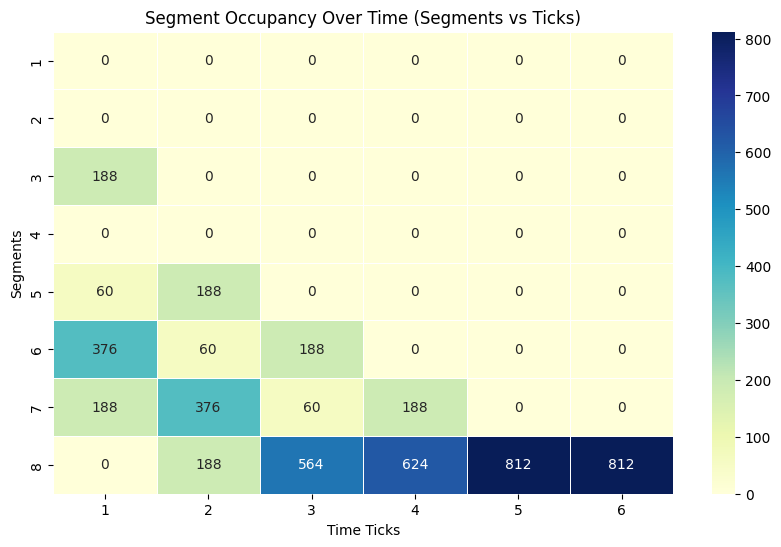

In [ ]:
visualize(solved_model1, groups_assignements1, dispatch_time1, input_data=random_input)

##Testing with increasing input size

i want to track the 3 types of solutions: 1-optimal, 2-feasible, 3-infeasible

for feasible and optimal solution i want to plot the instance size agianst the time taken and also memory allocation.

In [ ]:
def generate_ranges(start_group, end_group, num_examples_per_group, segment_range, fixed_ticks):
    ranges = []

    # Loop over group sizes from start_group to end_group
    for group_size in range(start_group, end_group + 1):
        # Loop over segment sizes from segment_range[0] to segment_range[1]
        for segment_size in range(segment_range[0], segment_range[1] + 1):
            # Generate the specified number of examples for each group and segment size
            for _ in range(num_examples_per_group):
                ranges.append([group_size, (segment_size, segment_size), fixed_ticks])

    return ranges

#define parameters
start_group = 3
end_group = 7
num_examples_per_group = 50
segment_range = (3, 7)
fixed_ticks = 6

#generate the ranges
generated_ranges = generate_ranges(start_group, end_group, num_examples_per_group, segment_range, fixed_ticks)

#printing the first few examples to show the structure
print(f"\t\t {'Group Size':<12} {'Segment Range':<20}   {'Ticks':<5}")
counter=1
for example in generated_ranges[:30]:
    print(f"instances {counter+49:<12} {example[0]:<10} {str(example[1]):<20} {example[2]:<5}")

    counter+=50

In [ ]:
print(len(generated_ranges))

1250


In [ ]:
def generate_unique_inputs(generated_ranges, statistics, feasibility_check):
    unique_inputs = []
    previous_inputs = []
    counter=0
    for index, generated_range in enumerate(generated_ranges):
        group_size, segment_range, fixed_ticks = generated_range

        while True:  #keep generating until we find a feasible and unique input
            random_input = input_data_generator(
                max_num_groups=group_size,
                num_segments_range=segment_range,
                max_ticks=(fixed_ticks, fixed_ticks),
                statistics=statistics
            )
            #check if the generated input is solvable and unique
            if feasibility_check(random_input) and random_input not in previous_inputs:
                unique_inputs.append(random_input)
                previous_inputs.append(random_input)
                break
            else:
                #print(f"Regenerating input for index {index} due to infeasibility or duplication.")
                continue

    return unique_inputs

In [ ]:
statistics = (batch_size, frequencies)

unique_inputs = generate_unique_inputs(generated_ranges, statistics, feasibility_check)

for i, unique_input in enumerate(unique_inputs[999:1000]):
    print(f"Unique Input {i+1}:")
    print(len(unique_input[0]), len(unique_input[1]), unique_input[2])
    #print_input_data(unique_input)


Unique Input 1:
6 6 6


In [ ]:
print(len(generated_ranges), len(unique_inputs))

1250 1250


In [ ]:
def test_model_scalability(data):
    feas_log = [] #logs both optimal and feasible solutions to later visualize it agianst the time taken to solve the instance
    inf_log = []
    inf_data = []
    times = []
    sizes = []

    for input_data in data:

        start_time = time.time()

        m, r, d = scheduling_model_corrected(input_data)

        end_time = time.time()
        instance_size = (len(input_data[0]), len(input_data[1]), input_data[2])

        sizes.append(instance_size)
        times.append(end_time - start_time)

        if m.status == gp.GRB.Status.OPTIMAL:
            feas_log.append(instance_size)
        elif m.status == gp.GRB.Status.INFEASIBLE:
            inf_log.append(instance_size)
            inf_data.append(input_data)

    return feas_log, inf_log, inf_data, times, sizes

feas_log, inf_log, inf_data, times, sizes = test_model_scalability(unique_inputs)

Streaming output truncated to the last 5000 lines.
Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 336 columns and 630 nonzeros
Model fingerprint: 0x5a4ecbe7
Variable types: 0 continuous, 336 integer (336 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 6.000001e+10

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 6e+10 

Optimal solution found (tolerance 1.00e-04)
B

In [ ]:
def plot_time_vs_instance_size(sizes, times):
    """
    Plots solver time vs instance size (groups * segments * ticks).
    """
    instance_sizes = [g * s * t for g, s, t in sizes]
    plt.scatter(instance_sizes, times, marker='o')
    plt.title('Solver Time vs Instance Size')
    plt.xlabel('Instance Size (groups * segments * ticks)')
    plt.ylabel('Time (seconds)')
    plt.grid(True)
    plt.show()

def plot_feasibility_ratio(feas_log, inf_log):
    """
    Plots the ratio of feasible to infeasible instances.
    """
    feasible_count = len(feas_log)
    infeasible_count = len(inf_log)
    total_instances = feasible_count + infeasible_count

    feasibility_ratio = feasible_count / total_instances if total_instances > 0 else 0
    plt.bar(['Feasible', 'Infeasible'], [feasibility_ratio, 1 - feasibility_ratio])
    plt.title('Feasibility vs Infeasibility')
    plt.ylabel('Percentage')
    plt.show()


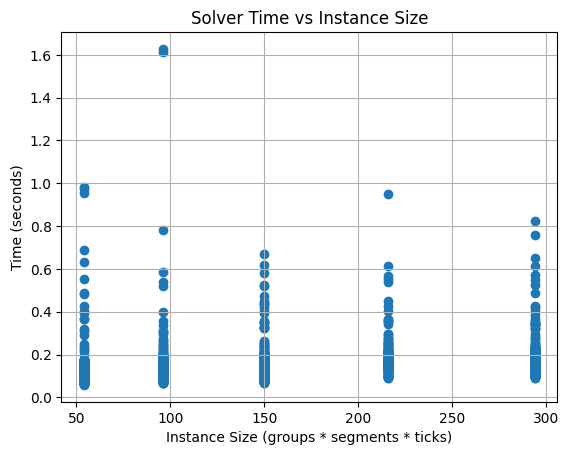

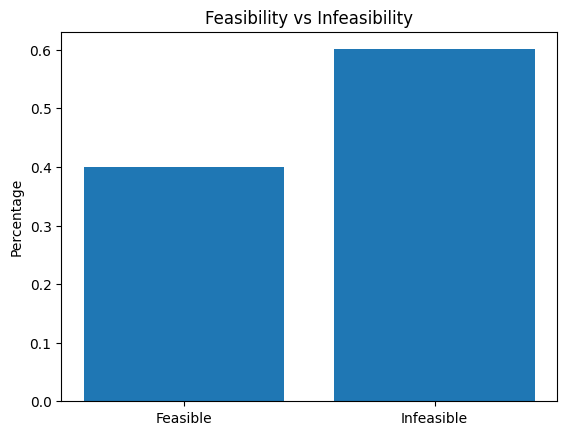

In [ ]:
plot_time_vs_instance_size(sizes, times)

plot_feasibility_ratio(feas_log, inf_log)

In [ ]:
print('the total mean of all instances:', np.mean(times),'s')

the total mean of all instances: 0.17335204639434815 s


In [ ]:
print(len(feas_log), len(inf_log))
print('ratio:', len(feas_log)/len(inf_log))

499 751
ratio: 0.6644474034620506


###Saving the results of scalability in a file

saving

In [ ]:
import pickle

def save_scalability_results(filename, feas_log, inf_log, inf_data, times, sizes):
    data = {
        'feas_log': feas_log,
        'inf_log': inf_log,
        'inf_data': inf_data,
        'times': times,
        'sizes': sizes
    }

    with open(filename, 'wb') as f:
        pickle.dump(data, f)

In [ ]:
save_scalability_results('scalability_test_results.pkl', feas_log, inf_log, inf_data, times, sizes)

loading

In [ ]:
def load_scalability_results(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    return data['feas_log'], data['inf_log'], data['inf_data'], data['times'], data['sizes']

In [ ]:
feas_log, inf_log, inf_data, times, sizes = load_scalability_results('scalability_test_results.pkl')

In [ ]:
print_input_data(inf_data[0])

Generated Input Data:

Group Sizes:
[31, 26, 31, 26, 34]

Starting Segments (1 indicates start, 0 indicates no start):
Group 1: [0, 0, 1, 0, 0, 0, 0, 0]
Group 2: [1, 0, 0, 0, 0, 0, 0, 0]
Group 3: [0, 0, 1, 0, 0, 0, 0, 0]
Group 4: [1, 0, 0, 0, 0, 0, 0, 0]
Group 5: [0, 0, 0, 0, 1, 0, 0, 0]

Number of Ticks: 9

Segments Connections (1 indicates a connection, 0 indicates no connection):
Segment 1: [0, 0, 0, 1, 0, 0, 0, 0]
Segment 2: [0, 0, 1, 0, 0, 0, 0, 0]
Segment 3: [0, 0, 0, 1, 0, 0, 0, 0]
Segment 4: [0, 0, 0, 0, 0, 0, 1, 0]
Segment 5: [0, 0, 0, 0, 0, 1, 0, 0]
Segment 6: [0, 0, 0, 0, 0, 0, 1, 0]
Segment 7: [0, 0, 0, 0, 0, 0, 0, 1]
Dummy segment 8: [0, 0, 0, 0, 0, 0, 0, 0]

Road Capacities:
[164, 157, 181, 190, 209, 156, 138, 10000000000]


#System information

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [ ]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4400.31
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

RAM

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.7Gi       5.5Gi        47Mi       5.5Gi        10Gi
Swap:             0B          0B          0B


No gpu

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Disk

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         226G   33G  194G  15% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
tmpfs           6.4G   47M  6.3G   1% /var/colab
/dev/sda1       233G   57G  176G  25% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [ ]:
!pip freeze

absl-py==1.4.0
accelerate==0.34.2
ace_tools==0.0
aiohappyeyeballs==2.4.3
aiohttp==3.10.10
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.16
albumentations==1.4.15
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.19.0
astropy==6.1.4
astropy-iers-data==0.2024.10.14.0.32.55
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.22.0
bigquery-magics==0.4.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
Bottleneck==1.4.1
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.19.0
cloudpickle==3.1.0
cmake==3.30.4
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.

# **Note**: The old model was able to solve those instances somehow, not sure about the reliability of the solution found in the old model!

#A headache logical problem in the optimization modelling (Kinda solved it using approach 1 dummy final segment)

a problem in the modelling, how to make the model remove the groups after they are said to be scheduled?? extra dummy segment that has very large capacity? (failed) or removing the group after reaching the final segment? (idk how i tried to but failed)


In [ ]:
random_input = (
    [281, 235, 230],  # Group Sizes
    [[0, 1, 0, 0],    # Starting Segments for Group 1
     [0, 1, 0, 0],    # Starting Segments for Group 2
     [0, 1, 0, 0]],   # Starting Segments for Group 3
    7,  # Number of Ticks
    [[0, 0, 0, 1],    # Segment Connections for Segment 1
     [0, 0, 0, 1],    # Segment Connections for Segment 2
     [0, 0, 0, 1],    # Segment Connections for Segment 3
     [0, 0, 0, 0]],   # Segment Connections for Segment 4
    [437, 341, 389, 447]  # Road Capacities
)

print_input_data(random_input)

Generated Input Data:

Group Sizes:
[281, 235, 230]

Starting Segments (1 indicates start, 0 indicates no start):
Group 1: [0, 1, 0, 0]
Group 2: [0, 1, 0, 0]
Group 3: [0, 1, 0, 0]

Number of Ticks: 7

Segments Connections (1 indicates a connection, 0 indicates no connection):
Segment 1: [0, 0, 0, 1]
Segment 2: [0, 0, 0, 1]
Segment 3: [0, 0, 0, 1]
Segment 4: [0, 0, 0, 0]

Road Capacities:
[437, 341, 389, 447]


In [ ]:
import gurobipy as gp
from gurobipy import GRB
from typing import List, Tuple

def scheduling_model_2(input_data: Tuple[List[int], List[List[int]], int, List[List[int]], List[int]]
               ) -> Tuple[gp.Model, gp.tupledict, gp.tupledict]:

    group_sizes, starting_segments, num_time, segments_connections, road_capacities = input_data

    num_groups = len(group_sizes)
    num_segs = len(segments_connections)

    m = gp.Model("schedule2")
    r = m.addVars(num_groups, num_time, num_segs, lb=0, vtype=GRB.BINARY, name='group_presence_at_segment_at_a_tick')
    d = m.addVars(num_groups, num_time, vtype=GRB.BINARY, name="dispatch")

    m.setObjective(gp.quicksum(road_capacities[k] - gp.quicksum(r[i, j, k] * group_sizes[i] for i in range(num_groups))
                               for j in range(num_time) for k in range(num_segs)), sense=GRB.MINIMIZE)

    # Capacity constraint for each segment at each tick
    for j in range(num_time):
        for k in range(num_segs):
            m.addConstr(gp.quicksum(r[i, j, k] * group_sizes[i] for i in range(num_groups)) <= road_capacities[k],
                        f"capacity_constraint_{j}_{k}")

    # Each group must be dispatched exactly once (at one tick)
    for i in range(num_groups):
        m.addConstr(gp.quicksum(d[i, j] for j in range(num_time)) == 1,
                    f"group_{i+1}_single_dispatch_tick")

    # Ensure that if a group is dispatched at tick j, it is present at its starting segment
    for i in range(num_groups):
        for j in range(num_time):
            for s in range(num_segs):
                if starting_segments[i][s] == 1:
                    m.addConstr(r[i, j, s] == d[i, j],
                                name=f"group_{i+1}_dispatch_at_correct_segment_at_tick_{j+1}")
                else:
                    m.addConstr(r[i, j, s] == 0,
                                name=f"group_{i+1}_not_dispatch_at_wrong_segment_at_tick_{j+1}")

    # Ensure groups move from one segment to another in connected segments
    for i in range(num_groups):
        for j in range(num_time - 1):
            for s1 in range(num_segs):
                for s2 in range(num_segs):
                    if segments_connections[s1][s2] == 1:
                        # Ensure group can move to the next segment
                        m.addConstr(r[i, j, s1] - r[i, j + 1, s2] <= 0,
                                    name=f"group_{i+1}_move_from_{s1+1}_to_{s2+1}_at_tick_{j+1}_to_{j+2}")
                    elif segments_connections[s1][s2] == 0:
                        # Prevent movement to unconnected segments
                        m.addConstr(r[i, j, s1] + r[i, j + 1, s2] <= 1,
                                    name=f"group_{i+1}_no_move_from_{s1+1}_to_{s2+1}_at_tick_{j+1}_to_{j+2}")

    # Ensure that once a group reaches the final segment, it stays there
    for i in range(num_groups):
        for j in range(num_time - 1):
            m.addConstr(r[i, j, num_segs - 1] == r[i, j + 1, num_segs - 1],
                        name=f"group_{i+1}_stay_in_final_segment")

    # Dispatch should consider capacity constraint for the starting segment
    for i in range(num_groups):
        for j in range(num_time):
            for s in range(num_segs):
                if starting_segments[i][s] == 1:  # Check if the group starts at segment s
                    m.addConstr(d[i, j] * group_sizes[i] <= road_capacities[s],
                                name=f"capacity_check_at_dispatch_group_{i+1}_segment_{s+1}_tick_{j+1}")

    # Optimize the model
    m.optimize()

    return m, r, d








# Input data for the given instance
random_input = (
    [281, 235, 230],  # Group Sizes
    [[0, 1, 0, 0],    # Starting Segments for Group 1
     [0, 1, 0, 0],    # Starting Segments for Group 2
     [0, 1, 0, 0]],   # Starting Segments for Group 3
    7,  # Number of Ticks
    [[0, 0, 0, 1],    # Segment Connections for Segment 1
     [0, 0, 0, 1],    # Segment Connections for Segment 2
     [0, 0, 0, 1],    # Segment Connections for Segment 3
     [0, 0, 0, 0]],   # Segment Connections for Segment 4
    [437, 341, 389, 44700]  # Road Capacities
)

# Solve the instance
solved_model, groups_assignments, dispatch_time = scheduling_model_2(random_input)

# Extract solution
solution = []
if solved_model.status == GRB.OPTIMAL:
    for i in range(len(random_input[0])):  # For each group
        for j in range(random_input[2]):  # For each tick
            for k in range(len(random_input[3])):  # For each segment
                if groups_assignments[i, j, k].X == 1:
                    solution.append((f"Group {i+1}", f"Tick {j+1}", f"Segment {k+1}", f"Group Size: {random_input[0][i]}"))

# Print the solution
for sol in solution:
    print(sol)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 442 rows, 105 columns and 843 nonzeros
Model fingerprint: 0xdb074412
Variable types: 0 continuous, 105 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e+02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 441 rows and 105 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [ ]:
print_solution(solved_model, groups_assignments, dispatch_time, input_data=random_input)

Optimal solution found:

Group 1 at tick 5 in segment 2: 281.0
d[1,5] = 1.0
Group 2 at tick 4 in segment 2: 235.0
d[2,4] = 1.0
Group 3 at tick 6 in segment 2: 230.0
d[3,6] = 1.0


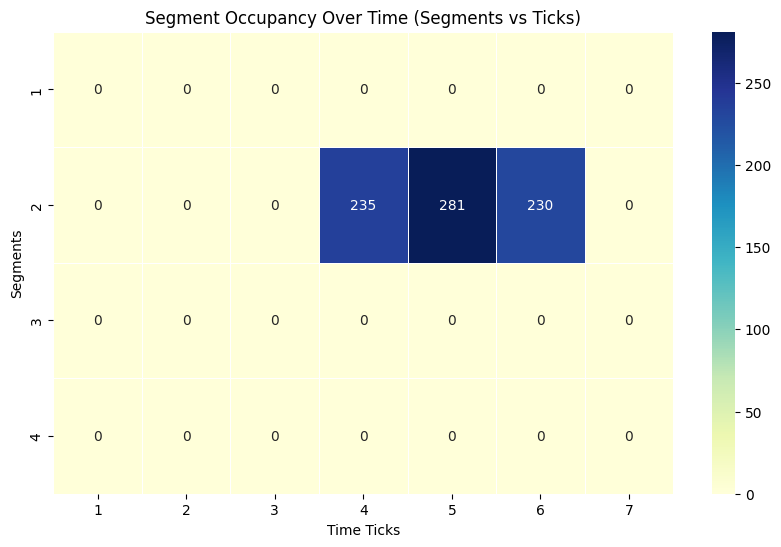

In [ ]:
visualize(solved_model, groups_assignments, dispatch_time, input_data=random_input)

In [ ]:
if solved_model.status == GRB.INFEASIBLE:
        solved_model.computeIIS()
        solved_model.write("infeasible_model.ilp")
        print("Infeasibility found. Check 'infeasible_model.ilp' for the conflicting constraints.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0       183         -         0         0         0           0s
       41        41        41         0         0         0           0s

IIS computed: 41 constraints, 0 bounds
IIS runtime: 0.04 seconds (0.00 work units)
Infeasibility found. Check 'infeasible_model.ilp' for the conflicting constraints.
